# Breaking the CAPTCHA

For my final project I decided to develop something slightly rebelious. Although I am not at the level where I develop Machine Learning models to improve assignment scores or automatically write code for myself, I still found an interesting application of Machine Learning - fighting something that people created against technology. 

Automating mundane tasks with bots can really speak to the "geekiness" (coolness) of a developer. Thus, I am naturally sad when such thing as CAPTCHA stands on a way of a great developer doing cool automation just because the bot doesn't recognize CAPTCHA symbols. That's why I was excited to develop a Machine Learning model that would try and read the CAPTCHA. 

Again, just to remind, I am very far from being cool enough to make something that breaks modern CAPTCHA but I am happy to try myself with older CAPTCHA. Thus, the model below aims to read one of the first CAPTCHA generations and output their text. 

While playing with this project I also found many companies doing the same thing. However, if you follow this link (the first Google result for CAPTCHA-breaker) https://capmonster.cloud/en/Demo/ you will find that its performance is just ridiculous - terribly inaccurate (you can test with folder images).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

# from google.colab import drive
# drive.mount('/content/drive')

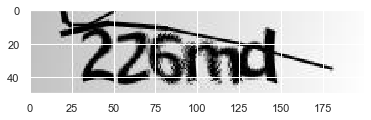

In [4]:
# checking out ana example of image from the dataset
img = plt.imread("Kaggle_Captcha_data/226md.png")
plt.imshow(img)

### Data encoding

I decided to use one-hot encoding for the data instead of categorically encoding the symbols as integers. This way we are on the safe side - no arithmetical or numerical connections can be established between the symbols which is exactly what we want. To have one-hot encoding, we need to get all unique symbols from all labels and assign each symbol a unique numerical value that we'll later represent with an index.

In [5]:
# getting the names of all files and looking at all
# possible target variable values (answers to the CAPTCHA)
files = os.scandir("Kaggle_Captcha_data")
files = [i.name for i in files]

all_symbols = ""
for i in range(len(files)):
    all_symbols += files[i].split(".")[0]
    
uniques = list(set(all_symbols))  

encoding_dict = {uniques[i]: i for i in range(len(uniques))}
print(f"Numerical encoding of each character: {encoding_dict}")

Numerical encoding of each character: {'c': 0, 'b': 1, 'x': 2, '2': 3, 'n': 4, '7': 5, 'm': 6, '3': 7, '4': 8, 'p': 9, 'e': 10, '5': 11, 'd': 12, 'g': 13, 'f': 14, '6': 15, 'w': 16, 'y': 17, '8': 18}


In [6]:
# building a DataFrame with all the information about the dataset
# (this will be convenient later when shaping X and y)
data = pd.DataFrame(columns=["filename", "label", "char1", 
                             "char2", "char3", "char4", "char5"])
for entry in range(len(files)):
    data.loc[entry, "filename"] = files[entry]
    data.loc[entry, "label"] = files[entry].split(".")[0]
    data.loc[entry, "char1"] = files[entry][0]
    data.loc[entry, "char2"] = files[entry][1]
    data.loc[entry, "char3"] = files[entry][2]
    data.loc[entry, "char4"] = files[entry][3]
    data.loc[entry, "char5"] = files[entry][4]

print(data.shape)
data.reset_index(drop=True, inplace=True)
data.head()

(1070, 7)


,filename,label,char1,char2,char3,char4,char5
0,226md.png,226md,2,2,6,m,d
1,22d5n.png,22d5n,2,2,d,5,n
2,2356g.png,2356g,2,3,5,6,g
3,23mdg.png,23mdg,2,3,m,d,g
4,23n88.png,23n88,2,3,n,8,8


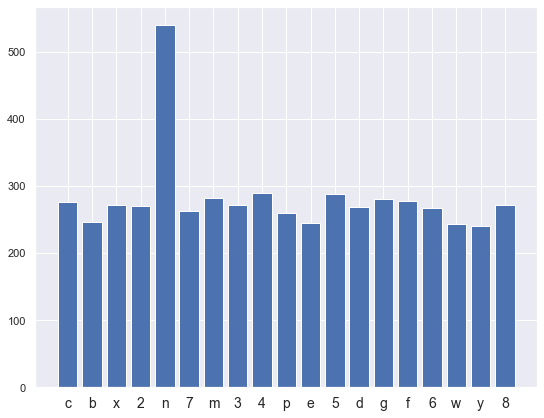

In [7]:
# getting the values count to understand the target variable distribution
counts_dict = {}
for char in set(all_symbols):
    counts_dict[char] = all_symbols.count(char)
    
plt.figure(figsize=(9, 7))
plt.bar(counts_dict.keys(), counts_dict.values())
plt.xticks(size=14)
plt.show()


In [27]:
# shaping X and y sets
def prepare_data(df, test_proportion, encoding_dict, 
                 crop=True, random_state=0):
    """
    Prepare and split data to train vs. valid
    
    Arguments:
    ----------
    df : pd.DataFrame -- all image data organized into the dataframe
    test_proportion : float -- portion of entries to allocate for validation
    encoding_dict : dict -- contains numerical encoding for each variable
    
    Returns:
    -------
    X_train, X_valid : ndarray (m, 50, 200, 1) -- image pixel values
    y_train, y_valid : ndarray (m, 19 * 5) -- true picture encoding
    """    
    X, y = [], []
    for i in range(df.shape[0]):
        # creating X entry
        path = "Kaggle_Captcha_data/" + df.loc[i, "filename"]
        img = tf.io.read_file(path)
        img = tf.io.decode_png(img, channels=1)
        img = tf.image.convert_image_dtype(img, tf.float32)
        
        if crop:
            # cropping the image to zoom in on letters
            # (removing useless "white" data on image sides)
            img = tf.image.crop_to_bounding_box(img, offset_height=0,
                                           offset_width=25,
                                           target_height=50,
                                           target_width=125)
            # images might have different size after cropping
            # thus resizing to ensure equal size for all images
            img = tf.image.resize(img, size=[50, 200], 
                                  method="bilinear",
                                  preserve_aspect_ratio=False,
                                  antialias=False,
                                  name=None)
        X.append(img)
        
        # getting the label of the corresponding image 
        label = np.array([encoding_dict[x] for x in df.loc[i, "label"]])
        
        # to ensure proper learning for the CNN, we will encode the
        # target variable using one-hot encoding.
        # since all the answers contain exactly 5 symbols, we encode
        # them into one-hot matrix with shape (total_unique_characters, 5)
        onehot = np.zeros((len(encoding_dict.keys()), label.size))
        cols = np.arange(label.size)
        onehot[label, cols] = 1
        # flattening the outcome matrix to allow the CNN to learn
        y.append(onehot.flatten(order="F"))
    
    # splitting to train vs. valid
    np.random.seed(random_state)
    test_indices = np.random.randint(0, df.shape[0], 
                                     int(df.shape[0] * test_proportion))
    
    X_valid = [X[i] for i in test_indices]
    y_valid = [y[i] for i in test_indices]
    
    X_train = [X[i] for i in range(len(X)) if i not in test_indices]
    y_train = [y[i] for i in range(len(y)) if i not in test_indices]
    
    # reshaping to contain the number of images (m) as the first dimension
    X_train = tf.reshape(X_train, (-1, 50, 200, 1))
    X_valid = tf.reshape(X_valid, (-1, 50, 200, 1))
    y_train = tf.reshape(y_train, (len(y_train), -1))
    y_valid = tf.reshape(y_valid, (len(y_valid), -1))
    
    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = prepare_data(df=data,
                                                 test_proportion=0.1,
                                                 encoding_dict=encoding_dict)

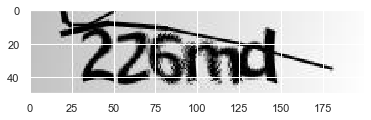

Original shape of the image: (50, 200, 1)

After converting type to float and reading with 1 channel.


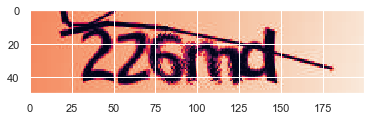


After cropping to bounding box.


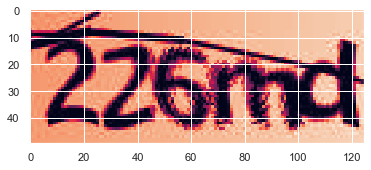


After resizing the image


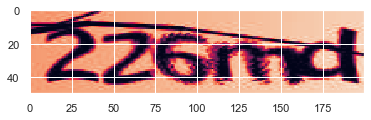

In [28]:
# showcasing the transformations on the image 
# when it goes through preprocessing
plt.imshow(img)
plt.show()
temp_img = tf.io.read_file("Kaggle_Captcha_data/226md.png")
img2 = tf.io.decode_png(temp_img, channels=1)
print(f"Original shape of the image: {img2.shape}")

img2 = tf.image.convert_image_dtype(img2, tf.float32)
print("\nAfter converting type to float and reading with 1 channel.")
plt.imshow(tf.reshape(img2, (50, 200)))
plt.show()

img2 = tf.image.crop_to_bounding_box(img2, offset_height=0,
                                           offset_width=25,
                                           target_height=50,
                                           target_width=125)
print("\nAfter cropping to bounding box.")
plt.imshow(tf.reshape(img2, (50, 125)))
plt.show()

img2 = tf.image.resize(img2, size=[50, 200], method="bilinear",
                                 preserve_aspect_ratio=False,
                                 antialias=False,
                                 name=None)
print("\nAfter resizing the image")
plt.imshow(tf.reshape(img2, (50, 200)))
plt.show()

In [29]:
# datagenerator to increase the number of training examples
# and ensure we cover some edge-cases (weird angles and cropped letters)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=15,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.07, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        shear_range = 0.2, # "stretches" image diagonally
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [30]:
def build_model():
  """
  Building the Convolutional Neural Network

  Note:
  ----
  I have iterated and changed the model architecture more than 50 times.
  Interestingly, significantly more complex architectures don't learn that
  well while this architecture is in a sweetspot for optimizing the loss function.
  
  Model architecture:
  ------------------
  I used traditional Convolutional blocks: set of filters with MaxPooling layer.
  I use MaxPooling only on the first 2 blocks since it decreases the dimension
  well enough and extracts the most important information. 
  My filters follow regular "expanding" pattern - the number of filters doubles
  with every block. Through iteration I found that filter size did not have
  strong impact on training while 2x2 and 3x3 filters performed slightly better.
  After Convolutional blocks I flatten the nodes and have two Dense layers plus
  the output layer that is shaped as (num_unique_symbols*5, 1). Because we have
  5 letters for each CAPTCHA, we simply flatten the one-hot positions and feed
  that as the outcome data.
  """
  model = keras.Sequential([
          layers.Conv2D(filters=16, kernel_size=(3, 3), 
                activation="relu", input_shape=(50, 200, 1)),
          layers.MaxPooling2D(pool_size=(2, 2)),
          
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          
          layers.Conv2D(filters=128, kernel_size=(2, 2), activation="relu"),
          
          layers.Flatten(),
          
          layers.Dense(units=512, activation="relu"),
          layers.Dropout(0.3),
          
          layers.Dense(units=256, activation="relu"),
          layers.Dropout(0.25),
          
          layers.Dense(units=5*len(encoding_dict.keys()), activation="sigmoid")
                            
  ])
  return model


model = build_model()

# I was very intentional in my choice of the optimizer and the loss.
# Adam allows us to have a smoother and thus more efficient gradient descend
# by applying a form of exponential smoothing to the gradient direction.
# binary crossentropy is used here because we only have two classes: 0 and 1
# if our output was encoded as integers instead of one-hot, we'd use sparse
# categorical crossentropy but since we are just looking for the most probable
# symbol in the text
model.compile(optimizer="Adam",
             loss="binary_crossentropy")


# stopping if no progress for 60 epochs
# and restoring the best validation weights
early_stopping = callbacks.EarlyStopping(patience=60,
                                        monitor="val_loss",
                                        min_delta = 0.003,
                                        verbose=2,
                                        restore_best_weights=True)

# decreasing the learning rate when the training loss stops decreasing
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                            factor=0.8, 
                                            patience=4, 
                                            verbose=1,
                                            mode='min', 
                                            restore_best_weights=True)

checkpoint_path = "drive/MyDrive/CS156_Assignment_final_checkpoints"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 198, 16)       160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 97, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 46, 64)         18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 45, 128)       

In [31]:
# fitting the model, it'll take about 30 minutes to converge with these parameters
# and the val_loss should be just below 0.04

# you can skip training by loading this model after training (2 cells below)
training = model.fit_generator(datagen.flow(X_train, y_train, batch_size=256),
                    validation_data=(X_valid, y_valid),
                    epochs=500,
                    callbacks=[early_stopping, plateau, cp_callback])

model.save(f"trained_model_{model.name}")


Epoch 1/500
4/4 [==============================] - ETA: 0s - loss: 0.5146
Epoch 00001: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 9s 2s/step - loss: 0.5146 - val_loss: 0.2553 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - ETA: 0s - loss: 0.2950
Epoch 00002: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 1s/step - loss: 0.2950 - val_loss: 0.2154 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - ETA: 0s - loss: 0.2510
Epoch 00003: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.2510 - val_loss: 0.2110 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - ETA: 0s - loss: 0.2339
Epoch 00004: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 8s 2s/step - loss: 0.2339 - val_loss: 0.2064 - lr: 0.0010
Epoc

Epoch 34/500
4/4 [==============================] - ETA: 0s - loss: 0.2040
Epoch 00034: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.2040 - val_loss: 0.1937 - lr: 0.0010
Epoch 35/500
4/4 [==============================] - ETA: 0s - loss: 0.2027
Epoch 00035: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.2027 - val_loss: 0.1942 - lr: 0.0010
Epoch 36/500
4/4 [==============================] - ETA: 0s - loss: 0.2018
Epoch 00036: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.2018 - val_loss: 0.1921 - lr: 0.0010
Epoch 37/500
4/4 [==============================] - ETA: 0s - loss: 0.2004
Epoch 00037: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.2004 - val_loss: 0.1903 - lr: 0.0010


Epoch 67/500
4/4 [==============================] - ETA: 0s - loss: 0.1731
Epoch 00067: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 1s/step - loss: 0.1731 - val_loss: 0.1512 - lr: 0.0010
Epoch 68/500
4/4 [==============================] - ETA: 0s - loss: 0.1717
Epoch 00068: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 1s/step - loss: 0.1717 - val_loss: 0.1493 - lr: 0.0010
Epoch 69/500
4/4 [==============================] - ETA: 0s - loss: 0.1709
Epoch 00069: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.1709 - val_loss: 0.1494 - lr: 0.0010
Epoch 70/500
4/4 [==============================] - ETA: 0s - loss: 0.1683
Epoch 00070: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 1s/step - loss: 0.1683 - val_loss: 0.1474 - lr: 0.0010


Epoch 100/500
4/4 [==============================] - ETA: 0s - loss: 0.1385
Epoch 00100: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 9s 2s/step - loss: 0.1385 - val_loss: 0.1173 - lr: 0.0010
Epoch 101/500
4/4 [==============================] - ETA: 0s - loss: 0.1377
Epoch 00101: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 9s 2s/step - loss: 0.1377 - val_loss: 0.1156 - lr: 0.0010
Epoch 102/500
4/4 [==============================] - ETA: 0s - loss: 0.1370
Epoch 00102: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 8s 2s/step - loss: 0.1370 - val_loss: 0.1161 - lr: 0.0010
Epoch 103/500
4/4 [==============================] - ETA: 0s - loss: 0.1369
Epoch 00103: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.1369 - val_loss: 0.1128 - lr: 0.0

Epoch 133/500
4/4 [==============================] - ETA: 0s - loss: 0.1121
Epoch 00133: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.1121 - val_loss: 0.0908 - lr: 0.0010
Epoch 134/500
4/4 [==============================] - ETA: 0s - loss: 0.1103
Epoch 00134: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.1103 - val_loss: 0.0906 - lr: 0.0010
Epoch 135/500
4/4 [==============================] - ETA: 0s - loss: 0.1101
Epoch 00135: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.1101 - val_loss: 0.0895 - lr: 0.0010
Epoch 136/500
4/4 [==============================] - ETA: 0s - loss: 0.1094
Epoch 00136: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.1094 - val_loss: 0.0890 - lr: 0.0

Epoch 166/500
4/4 [==============================] - ETA: 0s - loss: 0.0927
Epoch 00166: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.0927 - val_loss: 0.0761 - lr: 0.0010
Epoch 167/500
4/4 [==============================] - ETA: 0s - loss: 0.0923
Epoch 00167: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0923 - val_loss: 0.0785 - lr: 0.0010
Epoch 168/500
4/4 [==============================] - ETA: 0s - loss: 0.0909
Epoch 00168: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0909 - val_loss: 0.0752 - lr: 0.0010
Epoch 169/500
4/4 [==============================] - ETA: 0s - loss: 0.0896
Epoch 00169: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0896 - val_loss: 0.0746 - lr: 0.0

Epoch 198/500
4/4 [==============================] - ETA: 0s - loss: 0.0777
Epoch 00198: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0777 - val_loss: 0.0649 - lr: 6.4000e-04
Epoch 199/500
4/4 [==============================] - ETA: 0s - loss: 0.0760
Epoch 00199: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0760 - val_loss: 0.0641 - lr: 6.4000e-04
Epoch 200/500
4/4 [==============================] - ETA: 0s - loss: 0.0771
Epoch 00200: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0771 - val_loss: 0.0639 - lr: 6.4000e-04
Epoch 201/500
4/4 [==============================] - ETA: 0s - loss: 0.0771
Epoch 00201: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0771 - val_loss: 0.06

4/4 [==============================] - 7s 2s/step - loss: 0.0685 - val_loss: 0.0609 - lr: 4.0960e-04
Epoch 230/500
4/4 [==============================] - ETA: 0s - loss: 0.0686
Epoch 00230: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0686 - val_loss: 0.0595 - lr: 4.0960e-04
Epoch 231/500
4/4 [==============================] - ETA: 0s - loss: 0.0671
Epoch 00231: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0671 - val_loss: 0.0608 - lr: 4.0960e-04
Epoch 232/500
4/4 [==============================] - ETA: 0s - loss: 0.0678
Epoch 00232: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 9s 2s/step - loss: 0.0678 - val_loss: 0.0613 - lr: 4.0960e-04
Epoch 233/500
4/4 [==============================] - ETA: 0s - loss: 0.0697
Epoch 00233: saving model to drive/MyDrive\CS156_Assignmen

Epoch 261/500
4/4 [==============================] - ETA: 0s - loss: 0.0636
Epoch 00261: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.0636 - val_loss: 0.0579 - lr: 2.0972e-04
Epoch 262/500
4/4 [==============================] - ETA: 0s - loss: 0.0642
Epoch 00262: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 11s 3s/step - loss: 0.0642 - val_loss: 0.0574 - lr: 2.0972e-04
Epoch 263/500
4/4 [==============================] - ETA: 0s - loss: 0.0658
Epoch 00263: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0658 - val_loss: 0.0583 - lr: 2.0972e-04
Epoch 264/500
4/4 [==============================] - ETA: 0s - loss: 0.0639
Epoch 00264: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 00264: saving model to drive/MyDrive\CS156_Assignment_final_checkpoint

4/4 [==============================] - 7s 2s/step - loss: 0.0603 - val_loss: 0.0562 - lr: 6.8719e-05
Epoch 292/500
4/4 [==============================] - ETA: 0s - loss: 0.0606
Epoch 00292: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 8s 2s/step - loss: 0.0606 - val_loss: 0.0561 - lr: 6.8719e-05
Epoch 293/500
4/4 [==============================] - ETA: 0s - loss: 0.0617
Epoch 00293: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 7s 2s/step - loss: 0.0617 - val_loss: 0.0559 - lr: 6.8719e-05
Epoch 294/500
4/4 [==============================] - ETA: 0s - loss: 0.0637
Epoch 00294: ReduceLROnPlateau reducing learning rate to 5.497558740898967e-05.

Epoch 00294: saving model to drive/MyDrive\CS156_Assignment_final_checkpoints
4/4 [==============================] - 6s 2s/step - loss: 0.0637 - val_loss: 0.0562 - lr: 6.8719e-05
Epoch 295/500
4/4 [==============================] - 

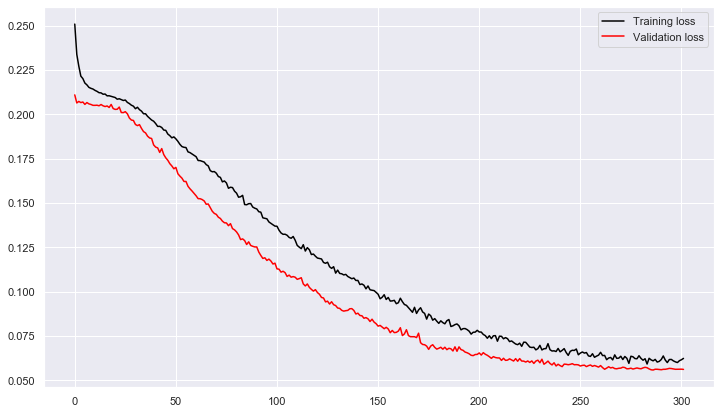

Number of epochs trained: 304
Training loss: 0.0623,	 validation_loss:0.0561


In [34]:
model_df = pd.DataFrame(training.history)

def plot_performance(data):
    """
    Plot training history of the model
    """
    # offset is just for visual reasons since
    # the first few losses are very high
    offset = 2
    loss = np.array(data["loss"])[offset:]
    val_loss = np.array(data["val_loss"])[offset:]
    
    plt.figure(figsize=(12, 7))
    plt.plot(loss, label="Training loss", color="black")
    plt.plot(val_loss, label="Validation loss", color="red")
    plt.legend()
    plt.show()
    print(f"Number of epochs trained: {len(loss)+offset}")
    print(f"Training loss: {round(loss[-1], 4)},\t validation_loss:{round(val_loss[-1], 4)}")

plot_performance(model_df)

In [55]:
# downloading the model from the previously trained weights
def load_from_checkpoint(path):
  """ 
  Load the model from checkpoint callback 

  Note:
  -----
  Applies only if ran on Google Colab.
  Currently TF 2.0 on Colab has a bug - loading models from checkpoints
  does not work properly - the formatting is messed up and the
  trained weights become useless. Please see details here: shorturl.at/dsACU 
  """
  latest = tf.train.latest_checkpoint(path)
  loaded_model = build_model()
  loaded_model.compile(optimizer="adam",
                    loss="binary_crossentropy")
  loaded_model.load_weights(latest)
  return loaded_model

# same problem as described in function above applies to loading model
# instead of just loading its weights in Colab
loaded_model = load_model("trained_model_sequential_2")
# checking model performance on validation
loaded_model.evaluate(X_valid, y_valid)

#loaded_model = load_from_checkpoint("drive/MyDrive")
#loaded_model.evaluate(X_train, y_train)

4/4 [==============================] - 0s 54ms/step - loss: 0.0577


0.057684265077114105

In [69]:
# evaluating the model performance here
def reshape_preds(preds):
    """
    Reshape flattened vectors into (19, 5) matrices
    to get the predicted indices
    
    Arguments:
    ---------
    preds : ndarray -- probabilities of characters in
                    individual CAPTCHA pictures
                    
    Returns:
    -------
    new_preds : ndarray -- encoding of most likely variables
    """
    new_preds = [] # list with 5 most likely letters
    for prediction in range(len(preds)):
        temp = preds[prediction]
        # reshaping flattened network output into probability vectors
        # for each letter at every position (5 symbols total)
        reshaped = np.array([temp[i-19:i] for i in range(19, 96, 19)]).T
        new_preds.append(np.array(np.argmax(reshaped, axis=0)))
    return new_preds


def accuracy(prediction, truth, absolute=True):
    """
    Assess the accuracy of a single prediction
    
    Parameters:
    -----------
    prediction: list -- network's predicted 5 indices
    truth: list -- actual 5 indices
    absolute: bool -- if True: return 1 if all 5 indices matched, 0 otherwise
                      if False: return percentage of correctly predicted indices
    """
    if absolute:
      return prediction == truth
    if prediction.shape == truth.shape:
      return np.sum(prediction == truth) / truth.shape[0]
    raise Exception(f"Size of prediction and truth does not match "+
                    f"{prediction.shape} vs {truth.shape}.")
    
    
def assess_model(model, X_valid, y_valid, absolute=True):
    """
    Assess the overall model accuracy
    """
    # getting all the predictions
    preds = model.predict(X_valid)

    # reshaping predictions and validation outcome variable
    predictions = reshape_preds(preds)
    validations = reshape_preds(y_valid)

    # aggregating accuracies on each sample
    accuracies = []
    for i in range(len(predictions)):
        accuracies.append(accuracy(predictions[i], validations[i], absolute))

    return accuracies, predictions, validations

# we use X_valid and y_valid for assessment
accuracies, predictions, validations = assess_model(model, 
                                                    X_valid,
                                                    y_valid)

# percentage of CAPTCHAs correctly predicted
print(f"Percentage of entirely correctly predicted labels:" \
      f" {np.round(np.mean(accuracies), 3)}")


Percentage of entirely correctly predicted labels: 0.834


In [65]:
# let's train the model for some more time with larger
# batch_size for smoother updates
added_training = loaded_model.fit_generator(datagen.flow(X_train, y_train, batch_size=1024),
                                            validation_data=(X_valid, y_valid),
                                            epochs=20,
                                            callbacks=[early_stopping, plateau],
                                           verbose=0)



Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.8147498960606756e-05.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.25179988774471e-05.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.8014399392995985e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.4411519805435093e-05.


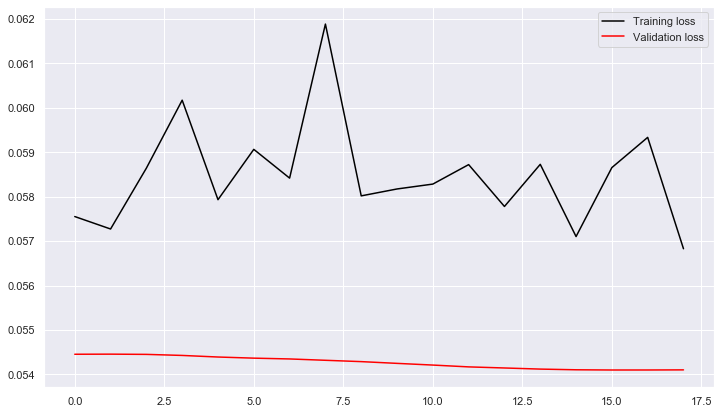

Number of epochs trained: 20
Training loss: 0.0568,	 validation_loss:0.0541


In [66]:
added_df = pd.DataFrame(added_training.history)
plot_performance(added_df)

Percentage of entirely correctly predicted labels: 0.854
Predicted label for the single CAPTCHA: 7p852
Actual label for the same CAPTCHA:      7p852


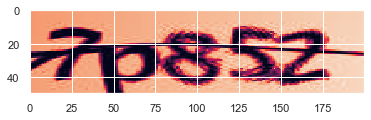

In [72]:
accuracies, predictions, validations = assess_model(loaded_model, 
                                                    X_valid,
                                                    y_valid)
# percentage of CAPTCHAs correctly predicted
print(f"Percentage of entirely correctly predicted labels:" \
      f" {np.round(np.mean(accuracies), 3)}")

def decode_label(label, encoding_dict):
    alternative_dict = {value:key for key, value in encoding_dict.items()}
    result = ""
    for i in label:
        result += alternative_dict[i]
        
    return result

# evaluating predictions by looking at the outputs
np.random.seed(100)
example = np.random.randint(0, len(X_valid))
plt.imshow(tf.reshape(X_valid[example], (50, 200)))
temp_label = decode_label(predictions[example], encoding_dict)
temp_true  = decode_label(validations[example], encoding_dict)
print(f"Predicted label for the single CAPTCHA: {temp_label}")
print(f"Actual label for the same CAPTCHA:      {temp_true}")

## Results.

As we can see - the accuracy is OK, 85/100 images is not bad. Considering that users are given more than 3 attempts for CAPTCHA, the chance of my model getting all CAPTCHAs wrong is $0.15^3 = 0.003$, 0.3%. With some additional training it could be better but, during model architecture iteration, I found that all models that were able to converge had simple architecture and stopped learning at about 0.05 loss.

At this point there are three ways to improve the accuracy:
1. **More complex model.** Although I tried to add another 3-10 layers and increase the number of units in each layer, the performance was not improving. On the contrary, it was so slow that training simply could not be completed. However, maybe adding even more layers and units could improve the accuracy with the resource tradeoff - the time and cost of training would be much much higher.
2. **Get more data.** This would be my preferred way - our dataset is quite small (~900 images for training). Even manual expansion of the dataset (pasting pictures from internet) could improve the perfomance, although I believe it would be possible to generate CAPTCHAs since the process for their generation is quite simple - apply distortions to the image of letters.
3. **Change model architecture.** Although Convolutional Neural Networks were considered a standard for any task involving images, we could also use RNNs to detect the letters. I have actually attempted to use RNNs but my experience was unsuccessfull - my Bidirectional LSTM could not converge properly and had a **terrible** overfitting problem. Funny enough - I had to crank up the Dropout so much that the model actually started diverging XD. Of course, we could also try to use Transformers, theoretically they are certain to do a better job, however, our data constraint would come into play with them. Transformers are usually very data-heavy, they need tons of data to learn because a bit less assumptions go into their learning. Thus, the fact that we had only 1000 images prevented me from building a Transformer model.
